In [1]:
using Plots, Random, Distributions, StatsBase, Printf, LaTeXStrings, 
    DataFrames, StatsPlots, KernelDensity
default(fillcolor=:lightgrey, markercolor=:black, markersize=2,
    grid=false, legend=false)

# The Gibss Sampler

## Gibbs Sampler for a bivarite normal distribution

Goal: Estimate $\mathbb{P}(X_1 \geq 0, X_2 \geq 0)$ for a $N(\mu, \Sigma)$, where
$$\mu = \left(\matrix{\mu_1 \\ \mu_2}\right) \quad \Sigma = \left(\matrix{\sigma_1^2 & \sigma_{12} \\ \sigma_{12} & \sigma_2^2}\right)$$

Marginals:
1. $f(X_1 | X_2) \sim N(\mu_1 + \frac{\sigma_{12}}{\sigma_2^2(x_2 - \mu_2)}, \sigma_1^2 - \frac{\sigma_{12}^2}{\sigma_2^2})$
1. $f(X_2 | X_1) \sim N(\mu_2 + \frac{\sigma_{12}}{\sigma_1^2(x_1 - \mu_1)}, \sigma_2^2 - \frac{\sigma_{12}^2}{\sigma_1^2})$

In [2]:
function gibbs_sample(;mu, sigma, N=1000)
    s12 = sigma[1, 2]
    s1 = sigma[1, 1]
    s2 = sigma[2, 2]
    X = reshape(zeros(N*2), N, 2)
    X[1,:] = mu
    d = Normal()
    for t in range(2, N)
        X[t, 1] = rand(d) * sqrt(s1 - (s12/s2)^2) + mu[1] + s12/s2*(X[t-1, 2] - mu[2])
        X[t, 2] = rand(d) * sqrt(s2 - (s12/s1)^2) + mu[2] + s12/s1*(X[t, 1] - mu[1])
    end
    X
end

gibbs_sample (generic function with 1 method)

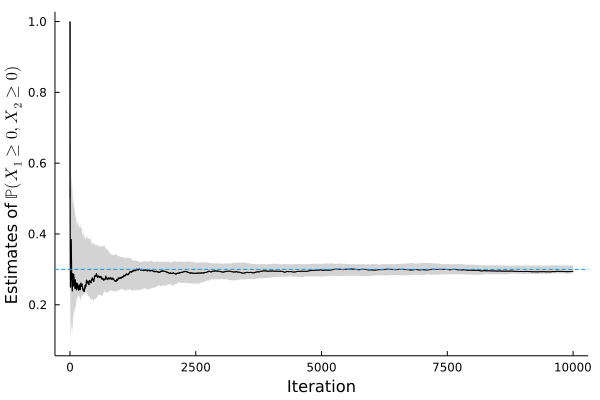

In [3]:

N = 10000
s = 0.3
sigma = [[1 s]; [s 1]]
mu = [0 0]

X = gibbs_sample(mu=mu, sigma=sigma, N=N)

P_min = P_max = P = cumsum(X[:, 1] .>= 0 .&& X[:, 2] .>= 0) ./ [1:1:N;]

for i in range(1, 100)
    X = gibbs_sample(mu=mu, sigma=sigma, N=N)
    P = cumsum(X[:, 1] .>= 0 .&& X[:, 2] .>= 0) ./ [1:1:N;]
    P_min = min.(P, P_min)
    P_max = max.(P, P_max)
end

plot([P P], fillrange=[P_min, P_max], color="black",
    xlab="Iteration", ylab="Estimates of "*L"\mathbb{P}(X_1 \geq 0, X_2 \geq 0)")
hline!([s], linestyle=:dash, color=1)

### Comparison of samples with low and high correlation

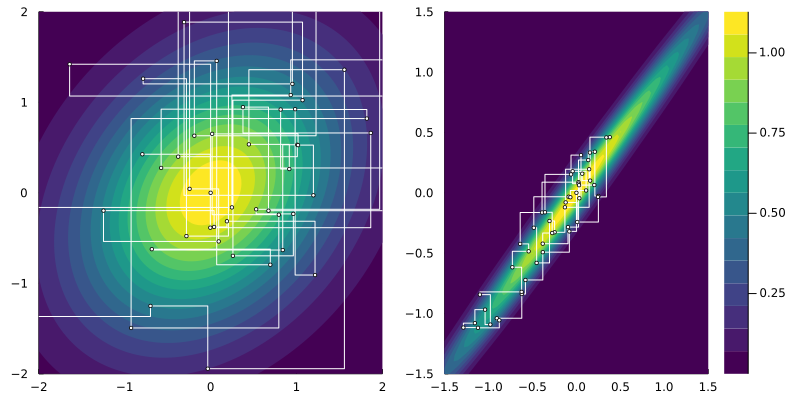

In [4]:
N = 50
sigmal = [1 0.3; 0.3 1]
sigmah = [1 0.99; 0.99 1]
mu = [0, 0]

# sample
Xl = gibbs_sample(mu=mu, sigma=sigmal, N=N)
Xh = gibbs_sample(mu=mu, sigma=sigmah, N=N)
# Normal densities
dl = MvNormal(mu, sigmal)
dh = MvNormal(mu, sigmah)
X = range(-2, 2, length=100)
Y = range(-2, 2, length=100)
Zl = [pdf(dl, [x,y]) for y in Y, x in X]
Zh = [pdf(dh, [x,y]) for y in Y, x in X]

default()
contourf(X, Y, Zl, color=:viridis, width=0.01, layout=(1,2), subplot=1,
     ylim=(-2, 2), xlim=(-2, 2), size = (800, 400), legend=false)
plot!(Xl[:,1], Xl[:, 2], linetype=:steppre, subplot=1, color="white")
scatter!(Xl[:,1], Xl[:, 2], subplot=1, markersize=2, color="white")

contourf!(X, Y, Zh, color=:viridis, width=0.01, subplot=2, legend=false,
    ylim=(-1.5, 1.5), xlim=(-1.5, 1.5))
plot!(Xh[:,1], Xh[:, 2], linetype=:steppre, subplot=2, 
    ylim=(-1.5, 1.5), xlim=(-1.5, 1.5), color="white")
scatter!(Xh[:,1], Xh[:, 2], subplot=2, markersize=2, color="white")

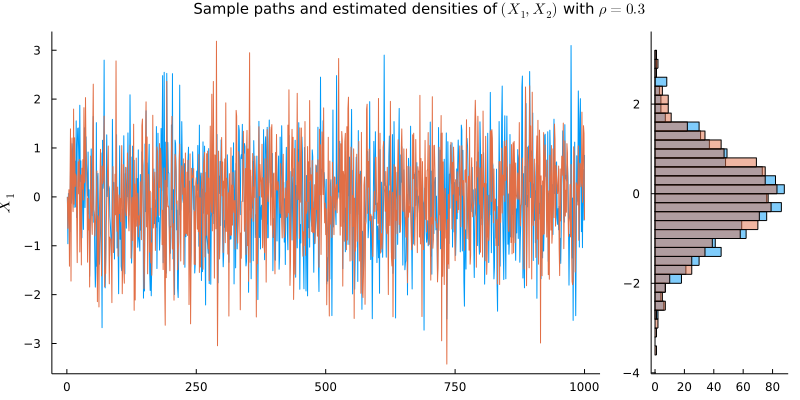

In [5]:
N = 1000
# sample
Xl = gibbs_sample(mu=mu, sigma=sigmal, N=N)
Xh = gibbs_sample(mu=mu, sigma=sigmah, N=N)

#plot low-correlated sample
layout = @layout [a{0.1h} ;
                  c d{0.2w}]
default(legend=false, grid=false)
plot(
    title="Sample paths and estimated densities of "*L"(X_1, X_2)"*" with "*L"\rho=0.3", 
    titlefontsize=10, layout=layout, subplot=1, framestyle=:nothing, 
    showaxis=false, xticks=false, yticks=false, bottom_margin = -50Plots.px,
    size = (800, 400)
)
plot!(Xl, subplot=2, ylab=L"X_1")
histogram!(Xl[:,1], subplot=3, orientation=:h, bins=40, fillcolor=1, fillalpha=0.5)
histogram!(Xl[:,2], subplot=3, orientation=:h, bins=40, fillcolor=2, fillalpha=0.5)

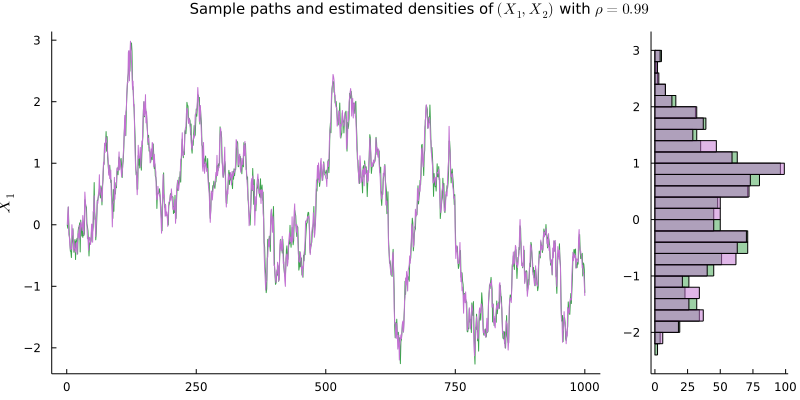

In [6]:
#plot high-correlated sample
layout = @layout [a{0.1h} ;
                  c d{0.2w}]
plot(
    title="Sample paths and estimated densities of "*L"(X_1, X_2)"*" with "*L"\rho=0.99", 
    titlefontsize=10, layout=layout, subplot=1, framestyle=:nothing, 
    showaxis=false, xticks=false, yticks=false, bottom_margin = -50Plots.px,
    size = (800, 400)
)
plot!(Xh, subplot=2, ylab=L"X_1", color=[3 4])
histogram!(Xh[:,1], subplot=3, orientation=:h, bins=40, fillcolor=3, fillalpha=0.5)
histogram!(Xh[:,2], subplot=3, orientation=:h, bins=40, fillcolor=4, fillalpha=0.5)

## Poisson change point model

Model:
$$\begin{aligned}
Y_i &\sim Poi(\lambda_1) & i &= 1, \ldots, M \\
Y_i &\sim Poi(\lambda_2) & i &= M+1, \ldots, 
\end{aligned}
$$

Priors:
$$
\begin{aligned}
\lambda_i &\sim Gamma(\alpha_i, \beta_i) \\
M &\sim Uniform\{1, \ldots, n-1\}
\end{aligned}
$$

Marginals:
$$
\begin{aligned}
f(\lambda_1 | \mathbf{Y}, M) &\sim Gamma(\alpha_1 = \sum_{i=1}^M{y_i}, \beta_1 + M) \\
f(\lambda_2 | \mathbf{Y}, M) &\sim Gamma(\alpha_2 = \sum_{i=M+1}^n{y_i}, \beta_2 + n - M) \\
f(M | \mathbf{Y}, \lambda_1, \lambda_2) &\propto \lambda_1^{\sum_{i=1}^M{y_i}}\lambda_2^{\sum_{i=M+1}^n{y_i}}\exp((\lambda_2 - \lambda_1)M)
\end{aligned}
$$

In [7]:
function sample_M(Y, lambda1, lambda2)
    n = length(Y)
    log_p = (cumsum(Y[1:(n-1)]) .* log(lambda1)) + 
            ((sum(Y) .- cumsum(Y[1:(n-1)])) .* log(lambda2)) +
             (lambda2 - lambda1) .* [1:1:(n-1);]
    p = exp.(log_p)
    p = p ./ sum(p)
    StatsBase.sample([1:1:(n-1);], Weights(p), 1)
end

function gibbs_sample(;Y, alpha1, beta1, alpha2, beta2, M0, N=1000)
    n = length(Y)
    M = Array{Int64, 1}(undef, N)
    lambda1 = Array{Float64, 1}(undef, N)
    lambda2 = Array{Float64, 1}(undef, N)
    M[1] = M0
    lambda1[1] = (alpha1 - 1) / beta1
    lambda2[1] = (alpha2 - 1) / beta2
    for t in range(2, N)
        lambda1[t] = rand(Gamma(alpha1 + sum(Y[1:M[t - 1]]), 
                1 / (beta1 + M[t - 1])))
        lambda2[t] = rand(Gamma(alpha2 + sum(Y[(M[t - 1] + 1):end]), 
                1 / (beta2 + n - M[t - 1])))
        M[t] = sample_M(Y, lambda1[t], lambda2[t])[1]
    end
    DataFrame(lambda1=lambda1, lambda2=lambda2, M=M)
end

gibbs_sample (generic function with 1 method)

### Simulated data

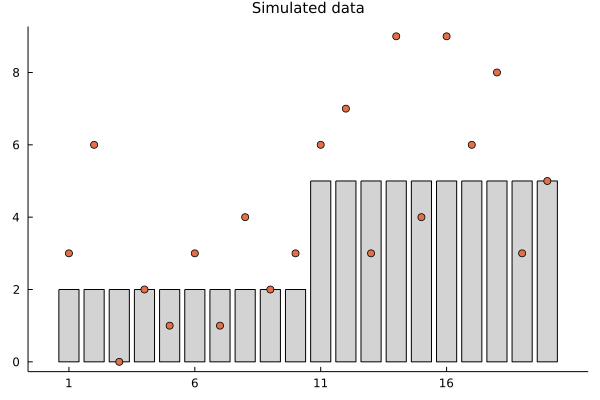

In [8]:
Random.seed!(0)
lambda1 = 2
lambda2 = 5
M1 = 10
M2 = 10
n = M1 + M2
d1 = Poisson(lambda1)
d2 = Poisson(lambda2)

Y1 = rand(d1, M1)
Y2 = rand(d2, M2)
Y = vcat(Y1, Y2)

default(fillcolor="lightgrey", titlefontsize=10)
bar(vcat(fill(lambda1, M1), fill(lambda2, M2)), xticks=[1:5:n;],
    title="Simulated data")
scatter!([1:1:n;], Y)

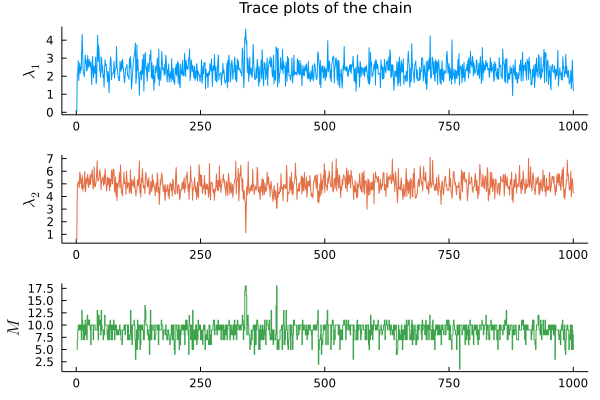

In [9]:
alpha1 = 1
beta1 = 1
alpha2 = 2
beta2 = 2
M0 = 5

chain1 = gibbs_sample(Y=Y, alpha1=alpha1, beta1=beta1, 
    alpha2=alpha2, beta2=beta2, M0=M0)

# trace plots
plot(chain1[!, "lambda1"], subplot=1, layout=(3,1), ylab = L"\lambda_1",
    title="Trace plots of the chain", color=1)
plot!(chain1[!, "lambda2"], subplot=2, ylab = L"\lambda_2", color=2)
plot!(chain1[!, "M"], subplot=3, linetype=:steppost, ylab = L"M", color=3)

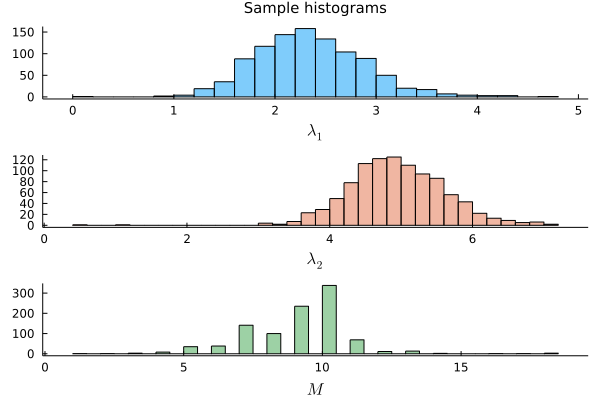

In [10]:
# histograms of samples
default(fillalpha=0.5)
histogram(chain1[!, "lambda1"], subplot=1, layout=(3,1), xlab = L"\lambda_1",
    title="Sample histograms", fillcolor=1)
histogram!(chain1[!, "lambda2"], subplot=2, xlab = L"\lambda_2", fillcolor=2)
histogram!(chain1[!, "M"], subplot=3, xlab = L"M", fillcolor=3)

### Real data

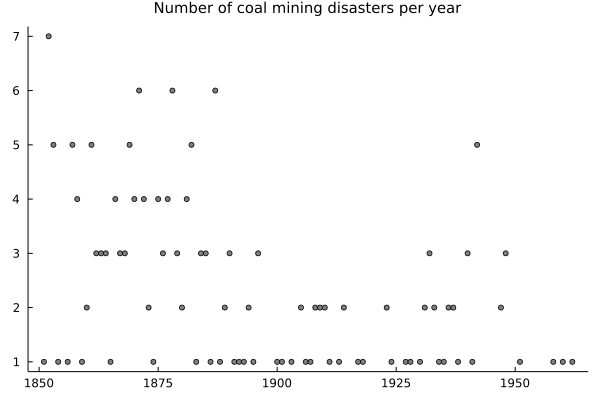

In [11]:
using RDatasets

coal = dataset("boot","coal")
coal[!, "year"] = Int.(round.(coal[!, "Date"]))

gd = groupby(coal, :year)
df = combine(gd, nrow => :count)
@df df scatter(:year, :count, markersize=3, markercolor="grey",
    title="Number of coal mining disasters per year")

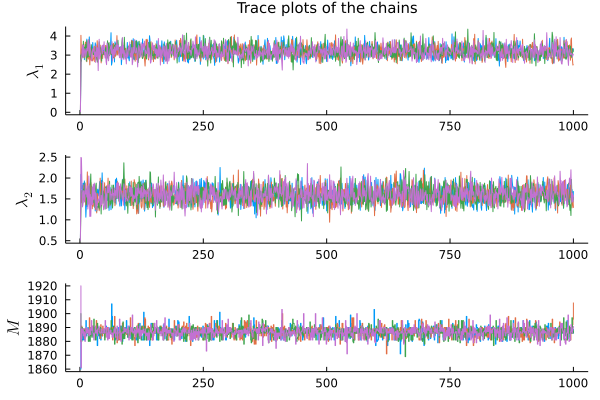

In [12]:
alpha1 = 1
beta1 = 1
alpha2 = 2
beta2 = 2

chain1 = gibbs_sample(Y=df[!, "count"], alpha1=alpha1, beta1=beta1, 
    alpha2=alpha2, beta2=beta2, M0=10)
chain2 = gibbs_sample(Y=df[!, "count"], alpha1=alpha1, beta1=beta1, 
    alpha2=alpha2, beta2=beta2, M0=30)
chain3 = gibbs_sample(Y=df[!, "count"], alpha1=alpha1, beta1=beta1, 
    alpha2=alpha2, beta2=beta2, M0=50)
chain4 = gibbs_sample(Y=df[!, "count"], alpha1=alpha1, beta1=beta1, 
    alpha2=alpha2, beta2=beta2, M0=70)

# trace plots
plot([chain1[!, "lambda1"] chain2[!, "lambda1"] chain3[!, "lambda1"] chain4[!, "lambda1"]], 
    subplot=1, layout=(3,1), ylab = L"\lambda_1",
    title="Trace plots of the chains")
plot!([chain1[!, "lambda2"] chain2[!, "lambda2"] chain3[!, "lambda2"] chain4[!, "lambda2"]],
    subplot=2, ylab = L"\lambda_2")
plot!(1850 .+ [chain1[!, "M"] chain2[!, "M"] chain3[!, "M"] chain4[!, "M"]]
    , subplot=3, linetype=:steppost, ylab = L"M")

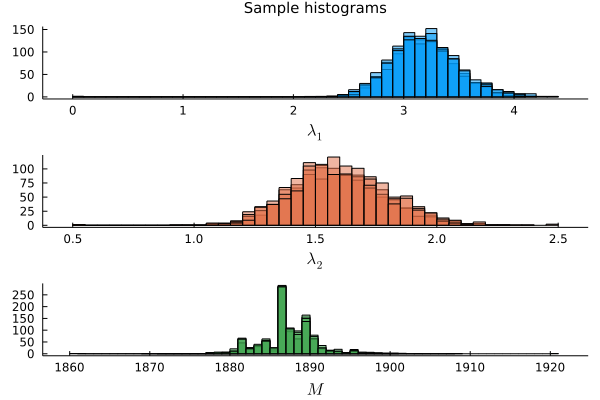

In [13]:
# histograms of samples
default(fillalpha=0.5)
histogram([chain1[!, "lambda1"] chain2[!, "lambda1"] chain3[!, "lambda1"] chain4[!, "lambda1"]],
    subplot=1, layout=(3,1), xlab = L"\lambda_1",
    title="Sample histograms", fillcolor=1)
histogram!([chain1[!, "lambda2"] chain2[!, "lambda2"] chain3[!, "lambda2"] chain4[!, "lambda2"]], 
    subplot=2, xlab = L"\lambda_2", fillcolor=2)
histogram!(1850 .+ [chain1[!, "M"] chain2[!, "M"] chain3[!, "M"] chain4[!, "M"]],
    subplot=3, xlab = L"M", fillcolor=3)

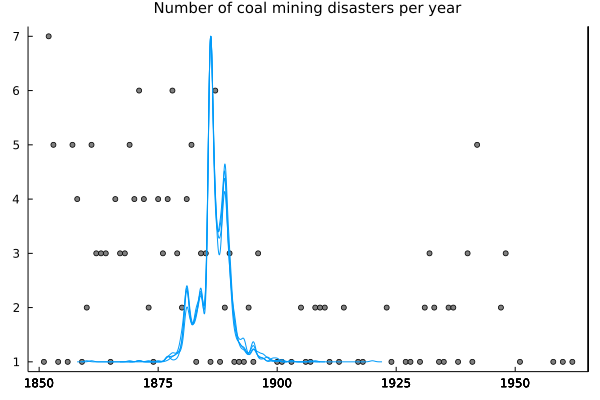

In [14]:
p = scatter(df[!,"year"], df[!,"count"], markersize=3, markercolor="grey",
    title="Number of coal mining disasters per year")
for c in [chain1, chain2, chain3, chain4]
    plot!(twinx(p), kde(1850 .+ c[!, "M"]), yticks = [1:250:50;])
end
p